<a href="https://colab.research.google.com/github/robert-srebrovic/hello-world/blob/master/Set_Similarity_Blog_Post_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

Patent landscaping is an analytical approach commonly used by corporations, patent offices, and academics to better understand the potential technical coverage of a large number of patents where manual review (i.e., actually reading the patents) is not feasible due to time or cost constraints.

Landscaping methods generally fall into one of two categories:  

1. Unsupervised: Given a portfolio of patents about which the user knows no prior information, utilize an unsupervised algorithm to generate topic clusters to provide users a better high-level overview of what that portfolio contains.
2. Supervised: Given a seed set of patents about which the user is confident covers a specific technology, identify other patents among a given set that are likely to relate to the same technology. 

This notebook creates an example of performing the supervised landscaping method using Python and BigQuery. It performs this by expanding a starting set of patents expected to cover some topic and ranking the results. The methodology overcomes the shortcomings of other lanscaping or expansion methods, namely: speed, cost and transparency.

The patent expansion performed here proceeds through the following steps:

1. Select a seed set of patents.
2. Organize and cluster the seed.
3. Run searches against the clusters.
4. Apply confidence functions to rank the search results.

# Pre-requisites
- A google cloud account with access to BigQuery. If you don't have an account yet, this [page](https://cloud.google.com/free/) outlines the process.
- SQL knowledge
- Python programming
- Knowledge of some often used python packages: Numpy, Pandas, sklearn, matplotlb

# Import Libraries and Authenticate Colab

In [0]:
#@markdown Import all the required python libraries and authenticate colab user.

# imports for clustering algorithm
import bisect
import collections
import math
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Charting
import matplotlib.pyplot as plt
import seaborn as sns

# General
import pandas as pd
from scipy import spatial
import time
import random
from sklearn import manifold

# BigQuery
from google.cloud import bigquery
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery

# Set BigQuery application credentials
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path_to_file.json"

In [0]:
#@markdown Insert bigquery project id.
bq_project_id = "bq_project_id" #@param {type:"string"}
client = bigquery.Client(project=bq_project_id)

# Selecting a Seed Set

Performing a landscape search on a set of patents first requires a seed set for the search to be performed against. In order to produce a high-quality search, the input patents should themselves be closely related. The more closely related the input set is, the more confidence you can have in the results. A set of completely random patents will likely yield noisy and more uncertain results.

The input set could span a CPC code, a technology, an assignee, an inventor, etc., or a specific list of patents covering some known technological area. In this walkthrough a term (word) is used to find a seed set. In the BigQuery public patents data project, there is a “top terms” field available for all patents in the “google_patents_research.publications” table. The field contains 10 of the most important terms used in a patent. The terms can be unigrams (ex. “aeroelastic”, “genotyping”, “engine”) or bi-grams (ex. “electrical circuit”, “background noise”, “thermal conductivity”).

With an input set selected, you’ll next need a representation of a patent. Rather than using the entire text of a patent or discrete features of a patent, it’s more consumable to use an embedding for each patent. Embeddings are a learned representation of a data input through some type of model, often with a neural network architecture. They reduce the dimensionality of an input set by mapping the most important features of the inputs to a vector of continuous numbers. A benefit of using embeddings is the ability to calculate distances between them, since several distance measures between vectors exist.

You can find a set of patent embeddings on BigQuery. The patent embeddings were built using a machine learning model that predicted a patent's CPC code from its text. Therefore the learned embeddings are a vector of 64 continuous numbers intended to encode the information in a patent's text. Distances between the embeddings can then be calculated and used as a measure of similarity between two patents.

In the following example query (performed in BigQuery), we’ve selected a random set of US patents (and collected their embeddings) granted after Jan 1, 2005 with a top term of "neural network".


In [3]:
search_term = "neural network" #@param {type:"string"}
return_count = 250 #@param {type:"integer"}

def create_query(search_term):

  q = r'''
  WITH 
  pubs as (
    SELECT DISTINCT 
      pub.publication_number
    FROM `patents-public-data.patents.publications` pub
      INNER JOIN `patents-public-data.google_patents_research.publications` gpr ON
        pub.publication_number = gpr.publication_number
    WHERE 
      pub.country_code = 'US' 
      AND "''' + search_term + '''" IN UNNEST(gpr.top_terms)
      AND pub.grant_date >= 20050101 AND pub.grant_date < 20100101
  )

  SELECT
    publication_number, url, 
    embedding_v1
  FROM 
    `patents-public-data.google_patents_research.publications`
  WHERE
    publication_number in (SELECT publication_number from pubs)
    AND RAND() <= '''+str(return_count)+'''/(SELECT COUNT(*) FROM pubs)
  '''

  return q

df = client.query(create_query(search_term)).to_dataframe()

if len(df) == 0:
  raise ValueError('No results for your search term. Retry with another term.')
else:
  print('Search complete for search term: \"{}\". {} random assets selected.'
  .format(search_term, len(df)))

embedding_dict = dict(zip(df.publication_number.tolist(), 
                          df.embedding_v1.tolist()))

df.head()


Search complete for search term: "neural network". 233 random assets selected.


,publication_number,url,embedding_v1
0,US-7143072-B2,https://patents.google.com/patent/US7143072B2,"[0.08031167, -0.08451577, -0.30692115, 0.00507..."
1,US-7366704-B2,https://patents.google.com/patent/US7366704B2,"[-0.11292107, 0.026738977, 0.1009645, -0.07474..."
2,US-7222002-B2,https://patents.google.com/patent/US7222002B2,"[-0.0066147367, -0.19784123, 0.04719364, 0.046..."
3,US-6915217-B2,https://patents.google.com/patent/US6915217B2,"[-0.19016707, -0.16650614, 0.040573042, 0.1097..."
4,US-6956506-B2,https://patents.google.com/patent/US6956506B2,"[-0.0030700967, -0.050479118, -0.17452878, 0.0..."


# Organizing the Seed Set

With the input set determined and the embedding representations retrieved, you have a few options for determining similarity to the seed set of patents.

Let’s go through each of the options in more detail.

#### Centroid

Calculating an overall embedding point—centroid, medoid, etc.— for the entire input set and performing similarity to that value. Under this method, one metric is calculated to represent the entire input set. That means that the input set of embeddings, which could contain information on hundreds or thousands of patents, ends up pared down to a single point. 

There are drawbacks to any methodology that is dependent on one point. If the value itself is not well selected, all results from the search will be poor. Furthermore, even if the point is well selected, the search depends on only that one embedding point, meaning all search results may represent the same area of a topic, technology, etc. By reducing the entire set of inputs to one point, you’ll lose significant information about the input set.

#### Seed Set Size x N

Seed set x N similarity, i.e., calculating similarity to all patents in the input set to all other patents. Doing it this way means you apply the vector distance metric used between each patent in the input set and all other patents in existence. This method presents a few issues: 
- Lack of tractability. Calculating similarity for (seed_set_size x all_patents) is an expensive solution in terms of time and compute. 
- Outliers in the input set are treated as equals to highly representative patents.
- Dense areas around a single point could be overrepresented in the results.
- Reusing the input points for similarity may fail to expand the input space.

#### Clustering

Clustering the input set and performing similarity to a cluster. We recommend clustering as the preferred approach to this problem, as it will overcome many of the issues presented by the other two methods. Using clustering, information about the seed set will be condensed into multiple representative points, with no point being an exact replica of its input. With multiple representative points, you can capture various parts of the input technology, features, etc. 

# Clustering the Seed

A couple of notes about the embeddings on bigquery:
- The embeddings are a vector of 64 values, meaning that data is high dimensional.
- As mentioned previously, the embeddings were trained in a prediction task, not explicitly trained to capture the "distance" between patents.

Based on the embedding training, the clustering algorithm needs to be able to effectively handle clusters of varying density. Since the embeddings were not trained to separate patents evenly, there will be areas of the embedding space that are more or less dense than others, yet represent similar information between documents.

Furthermore, with high-dimensional data, similarity measures can degrade rapidly. One possible approach to overcoming the dimensionality is to use a secondary metric to represent the notion of distance. Rather than using absolute distance values, it’s been shown that a ranking of data points from their distances (and removing the importance of the distance magnitudes) will produce more stable results with higher dimensional data. So our clustering algorithm should remove sole dependence on absolute distance.

It’s also important that a clustering method be able to detect outliers. When providing a large set of input patents, you can expect that not all documents in the set will be reduced to a clear sub-grouping. When the clustering algorithm is unable to group data in a space, it should be capable of ignoring those documents and spaces. 

Several algorithms exist that provide these characteristics, any of which can be applied to this problem in place of the algorithm used here. In this application, the shared nearest neighbor (SNN) clustering method is implemented for determining the patent grouping. 

SNN is a clustering method that evaluates the neighbors for each point in a dataset and compares the neighbors shared between points to find clusters. SNN is a useful clustering algorithm for determining clusters of varying density. It is good for high-dimensional data, since the explicit distance value is not used in its calculation; rather, it uses a ranking of neighborhood density. The complete clustering code is available in the linked GitHub repo.

For each cluster found, the SNN method determines a representative point for each cluster in order to perform a search against it. Two common approaches for representing geometric centers are centroids and medoids. The centroid simply takes the mean value from each of the 64 embedding dimensions. A medoid is the point in a cluster whose average dissimilarity to all objects in a cluster is minimized. In this walkthrough, we’re using the centroid method.

Below we have a python code snippet of the clustering application and calculations of some cluster characteristics, along with a visualization of the clustering results. The dimensions in the visualization were reduced using TSNE and outliers in the input set have grayed out. The results of the clustering can be seen by the like colors forming a cluster of patents.

In [0]:
#@markdown Create the shared nearest neighbor clustering algorithm.

"""Implementation of sharest nearest neighbor clustering.

Based on the following algorithm:
http://mlwiki.org/index.php/SNN_Clustering

Following paper:
www.dbs.ifi.lmu.de/~zimek/publications/SSDBM2010/SNN-SSDBM2010-preprint.pdf

Shared Nearest neighbor clustering is a clustering method that evaluates the
neighbors for each point in a dataset and compares those neighbors shared
between points to find clusters. SNN is a useful clustering algorithm for
determining clusters of varying density. It isgood for high dimensional data
since in those spaces the idea of a distance measurement to determine density
is not ideal and with snn distance density is replaced with neighborhood
density.

The patent document embeddings used by the set similarity app have no notion of
distance between all of the various sets of points so snn clustering used.

"""

import bisect
import collections
import math
import numpy as np
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


def shared_nearest_neighbor_graph(indices):
  """Create the shared nearest neighbor graph.

  Function will create the shared nearest neighbor graph from the nearest
  neighbor indices. Function uses the Jarvis-Patrick algorithm specified by the
  model.

  Args:
    indices: A list of lists wrepresenting the nearest neighbor indices of each
      point.

  Returns:
    snn_graph: List representing shared neighbors of each point.
  """
  count = len(indices)

  snn_graph = [[0 for i in range(count)] for j in range(count)]

  for i in range(0, count-1):
    for j in range(i + 1, count):
      if j in indices[i] and i in indices[j]:
        intersect = len(set(indices[i]).intersection(indices[j]))
        snn_graph[i][j] = intersect
        snn_graph[j][i] = intersect

  return snn_graph


def calculate_density(x, eps):
  """Calculate density of a point.

  Calculates density of a point based on a required level of epsilon density.

  Args:
    x: A list of integers representing the shared nearest neighbor counts.
    eps: An integer representing the required density of a point.
  Returns:
    density: An integer representing the density of a point.
  """
  # Bisect appears to be fastest, so used it versus others.
  density = len(x) - bisect.bisect(sorted(x), eps-1)
  return density


def snn_density_graph(shared_nearest_neighbors, eps):
  """Function to iterate through all points in graph and calculate density."""
  snn_density = [calculate_density(x, eps) for x in shared_nearest_neighbors]
  return snn_density


def find_core_points(snn_density, min_points):
  """Find core points from SNN density list and minimum points requirement."""
  return [i for i in range(len(snn_density)) if snn_density[i] >= min_points]


def find_core_neighbors(p, core_points_list, shared_nearest_neighbors, eps):
  """Find core point neighbors for a given point.

  For a specified point, p, check the SNN density values between p and all other
  core points.

  Args:
    p: A core point represented by an int index value.
    core_points_list: List of core points in the dataset.
    shared_nearest_neighbors: An SNN graph for a dataset.
    eps: The threshold level of density for between points.

  Returns:
    list: A list of core points which share greater than the epsilon threshold
      level of similar neighbors to the provided point p.

  """
  return [core_points_list[i] for i in range(0, len(core_points_list))
          if shared_nearest_neighbors[p][core_points_list[i]] >= eps]


def expand_cluster(labels, neighbor_core, core_points_list, c,
                   shared_nearest_neighbors, eps, visited):
  """Expand the cluster from the core neighbors.

  Function to take the cluster labels (that may be at some intermediate state)
  and expand a current set of core point neighbors to additional core point
  neighbors and update its cluster label.

  Args:
    labels: A list of cluster labels for each point in the data.
    neighbor_core: A set of core point neighbors.
    core_points_list: A list of core points in the data set.
    c: An int representing the current cluster label that is being expanded.
    shared_nearest_neighbors: A shared nearest neighbor graph.
    eps: The threshold level of density for between points.
    visited: A set of points already visited for cluster labeling.

  Returns:
    labels: An updated list of cluster labels for each point in the data.
  """

  while neighbor_core:
    p = neighbor_core.pop()
    if p in visited:
      continue
    labels[p] = c
    visited.add(p)
    neighbor_core.update(find_core_neighbors(p, core_points_list,
                                             shared_nearest_neighbors, eps))

  return labels


def core_points_from_clusters(core_points_list, shared_nearest_neighbors, eps):
  """Get core points from a cluster.

  Function computes the initial cluster labels for the core points in a dataset.

  Args:
    core_points_list: A list of core points.
    shared_nearest_neighbors: A shared nearest neighbor graph.
    eps: The threshold level of density for between points.

  Returns:
    labels: A list of cluster labels for each point in the data.
  """
  # Set to hold visited points.
  visited = set()
  # Cluster label for each point initialized to 0.
  labels = [0 for i in range(len(shared_nearest_neighbors))]
  # Used to denote the current cluster label.
  c = 0

  for i in range(len(core_points_list)):
    # Skip already visitied points, else add to visited set.
    p = core_points_list[i]
    if p in visited:
      continue
    visited.add(p)

    # Update cluster label and apply to current point.
    c = c + 1
    labels[p] = c

    # Expand labels from the core neighbors.
    neighbor_core = set(find_core_neighbors(p, core_points_list,
                                            shared_nearest_neighbors, eps))
    labels = expand_cluster(labels, neighbor_core, core_points_list, c,
                            shared_nearest_neighbors, eps, visited)

  return labels


def label_vote(matched_list):
  """Return most frequently occurring value in list (lowest index if tie)."""
  counted = collections.Counter(matched_list)
  return max(matched_list, key=counted.get)


def compute_final_labels(labels, core_points, shared_nearest_neighbors, eps):
  """Get the final cluster labels.

  Function evaluates the cluster status of non-core data points and tries to
  assign them to a cluster label. If no applicable cluster can be found, the
  cluster label is left as 0, representing an outlier. Assigning is done by
  a "vote" of the label of all core points that have greater than eps value to
  the point currently under consideration. We could also implement the label
  with the max neighbors instead of voting, though this nearly always ends in
  the same result.

  Args:
    labels: A list of cluster labels for each point in the data.
    core_points: List of core points.
    shared_nearest_neighbors: A shared nearest neighbor graph.
    eps: The threshold level of density for between points.

  Returns:
    labels: A list of cluster labels for each point in the data.
  """
  for i in range(len(labels)):
    # If a point is a core point, its cluster has been assigned and we continue.
    if i in core_points:
      continue

    ms = [labels[k] for k, j in enumerate(shared_nearest_neighbors[i])
          if j >= eps and k in core_points]

    if ms:
      updated_label = label_vote(ms)
      labels[i] = updated_label
    else:
      labels[i] = 0

  return labels


def calculate_cluster_centers(x, cluster_labels):
  """Calculated center point of each cluster."""

  cluster_set = set(cluster_labels)
  cluster_set.discard(0)  # Remove outliers.
  cluster_centers = {}

  for cluster in cluster_set:
    mask = np.in1d(cluster_labels, cluster)
    center = np.mean([x[i] for i in range(len(x)) if mask[i]], axis=0)
    cluster_centers[cluster] = list(center)

  return cluster_centers


def run_snn(x, metric, n_neighbors, min_points, eps):
  """Run shared nearest neighbor algorithm.

  Function takes the input data x and proceeds by running the shared nearest
  neighbor algorithm (http://mlwiki.org/index.php/SNN_Clustering). The algorithm
  follows these steps:
    Step 1 - Find Nearest Neighbors. Nearest neighbor data held in "indices".
    Step 2 - Construct SNN graph.
    Step 3 - Find the SNN density of each point.
    Step 4 - Find the core points.
    Step 5a - Find clusters from the core points.
    Step 5b - Align non-noise non-core points to clusters.
    Step 6 - Calculate cluster centroid.

  Step 5, the cluster assignment requires two steps. The first assigns clusters
  by determining if two core points are within the eps radius, in which case
  they belong to the same cluster. Afer the core points are examined, all points
  that are not within a radius of eps of a core point are discarded and labeled
  as noise.

  Args:
    x: Input data, a list of numeric (int or float) lists.
    metric: String value of the distance metric requested.
    n_neighbors: An integer for the number of neighbors to calculate for each
      data point in the dataset.
    min_points: Integer for minimum required points to determine a core point.
    eps: Float value representing the required neighbor density for forming
      clusters.

  Returns:
    labels: Cluster label for each data point.
    cluster_centers: Centroids for each cluster.
    indices: K nearest neighbors list for each data point.
    shared_nearest_neighbors: Shared nearest neighbor graph.
    core_points_list: List of core points.
  """

  if not n_neighbors:
    # If n_neighbors not set, fall to default values.
    n_neighbors = int(math.sqrt(len(x))/2)
    min_points = int(n_neighbors/2)
    eps = min_points
  else:
    # Set some default behavior for min_points and eps.
    if not min_points:
      min_points = int(n_neighbors/2)
    if not eps:
      eps = min_points

  # Step 1.
  # Add 1 since NearestNeighbors returns itself as a nearest point.
  nbrs = NearestNeighbors(n_neighbors + 1, metric=metric).fit(x)
  _, indices = nbrs.kneighbors(x)
  # Remove self as similar and convert to list (for speed in graph calc).
  indices = indices[:, 1:].tolist()  # converting from np array to list

  # Step 2.
  shared_nearest_neighbors = shared_nearest_neighbor_graph(indices)

  # Step 3.
  snn_density = snn_density_graph(shared_nearest_neighbors, eps)

  # Step 4.
  core_points_list = find_core_points(snn_density, min_points)

  # Step 5a.
  labels_init = core_points_from_clusters(core_points_list,
                                          shared_nearest_neighbors, eps)

  # Step 5b.
  labels = compute_final_labels(labels_init, core_points_list,
                                shared_nearest_neighbors, eps)

  # Step 6.
  cluster_centers = calculate_cluster_centers(x, labels)

  return labels, cluster_centers


class SharedNearestNeighbors(object):
  """Shared Nearest Neighbor clustering object."""

  def __init__(self, n_neighbors=None, min_points=None, eps=None):
    # Attributes
    self.labels = None
    self.cluster_centers = None
    self.neighbor_indices = None
    self.snn_graph = None
    self.core_points = None
    # Parameters
    # Keep distance to manhattan or cosine for now.
    self.metric = 'cosine' #'manhattan'
    self.n_neighbors = n_neighbors
    self.min_points = min_points
    self.eps = eps

  def fit(self, x):
    """Compute the shared nearest neighbor clustering."""
    self.labels, self.cluster_centers = run_snn(
        x, self.metric, self.n_neighbors, self.min_points, self.eps)
    return self

  def fit_predict(self, x):
    """Compute the clusters and return predicted cluster labels."""
    return self.fit(x).labels

  def silhouette(self, x):
    """Find silhouette scores and samples from the input dataset."""
    return (silhouette_score(x, self.labels, metric=self.metric),
            silhouette_samples(x, self.labels, metric=self.metric))

  def get_params(self):
    """Get parameters for estimator."""
    # TODO(srebrovic)
    pass

  def set_params(self):
    """Set parameters for estimator."""
    # TODO(srebrovic)
    pass

  def predict(self, x):
    """Predict closest cluster for each data point."""
    # TODO(srebrovic)
    pass

In [5]:
#@markdown Run the clustering algorithm, calculate cluster characteristics and visualize.

patents = embedding_dict.keys()
embeddings = embedding_dict.values()

snn = SharedNearestNeighbors()
snn.fit(embeddings)
cluster_labels = snn.labels
cluster_centers = snn.cluster_centers
cluster_lengths = collections.Counter(cluster_labels)

cluster_dict = {}
cluster_set = set(cluster_labels)

# Outliers in clustering will be labeled with 0 so no cluster calculated.
cluster_set.discard(0)

# For each cluster we calculate various characteristics and organize data.
for i in cluster_set:
  mask = np.in1d(cluster_labels, i)
  masked_embeddings = np.array(embeddings)[mask]
  centroid = cluster_centers[i]
  cluster_length = cluster_lengths[i]

  # Now from cluster center we calculate distance of all belonging points.
  centroid_sim = [spatial.distance.cosine(masked_embeddings[j], centroid)
                  for j in range(len(masked_embeddings))]

  cluster_dict[i] = {
      'centroid': centroid,
      'mean_sim': np.mean(centroid_sim),
      'std_sim': np.std(centroid_sim),
      'max_sim': np.max(centroid_sim),
      'min_sim': np.min(centroid_sim),
      'cluster_length': cluster_length,
  }

  print('Cluster {} \n\tSize: {}. Mean sim: {}. Standard deviation: {}.'.format(
      i, 
      str(cluster_dict[i]['cluster_length']), 
      str(round(cluster_dict[i]['mean_sim'], 3)), 
      str(round(cluster_dict[i]['std_sim'], 3)), 
  ))
  print('\tMax distance: {}. Min distance: {}.'.format(
      str(round(cluster_dict[i]['max_sim'], 3)), 
      str(round(cluster_dict[i]['min_sim'], 3))
  ))
  print('')


Cluster 1 
	Size: 7. Mean sim: 0.074. Standard deviation: 0.052.
	Max distance: 0.156. Min distance: 0.03.

Cluster 2 
	Size: 7. Mean sim: 0.11. Standard deviation: 0.019.
	Max distance: 0.136. Min distance: 0.077.

Cluster 3 
	Size: 15. Mean sim: 0.131. Standard deviation: 0.042.
	Max distance: 0.231. Min distance: 0.068.

Cluster 4 
	Size: 16. Mean sim: 0.157. Standard deviation: 0.04.
	Max distance: 0.234. Min distance: 0.107.

Cluster 5 
	Size: 8. Mean sim: 0.086. Standard deviation: 0.036.
	Max distance: 0.144. Min distance: 0.043.

Cluster 6 
	Size: 9. Mean sim: 0.119. Standard deviation: 0.057.
	Max distance: 0.199. Min distance: 0.046.

Cluster 7 
	Size: 9. Mean sim: 0.148. Standard deviation: 0.028.
	Max distance: 0.199. Min distance: 0.107.

Cluster 8 
	Size: 8. Mean sim: 0.106. Standard deviation: 0.05.
	Max distance: 0.171. Min distance: 0.048.

Cluster 9 
	Size: 4. Mean sim: 0.083. Standard deviation: 0.008.
	Max distance: 0.092. Min distance: 0.07.

Cluster 10 
	Size: 6. 

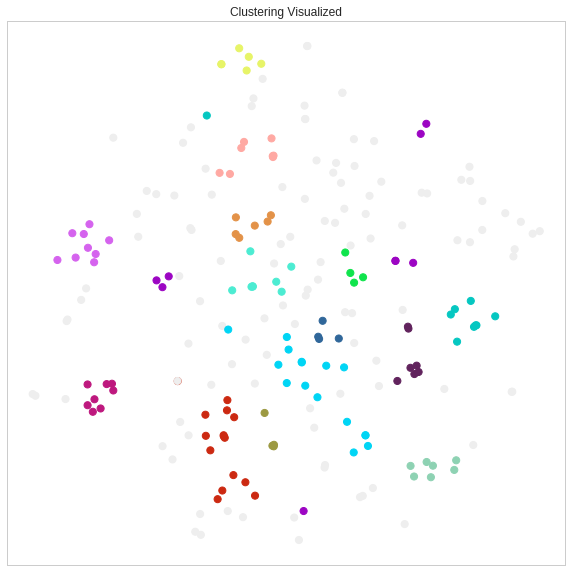

In [11]:
#@markdown Cluster Visualization.

palette = {
    i: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    for i in range(len(cluster_set)+1)
}

palette[0] = '#EEEEEE' # Set outlier color to gray
labels_colors = [palette[col] for col in cluster_labels]

n_neighbors = int(math.sqrt(len(embeddings)))
coordinates = manifold.TSNE(n_components=2).fit_transform(embeddings)

with plt.style.context("seaborn-whitegrid"):  
  fig = plt.figure(figsize=(10,10))
  plt.scatter(coordinates.T[0], coordinates.T[1], c=labels_colors, s=50)
  
  plt.xticks([])
  plt.yticks([])
  plt.title('Clustering Visualized')
  plt.show()

# Similarity Search

Once the cluster groups and their centers have been determined, you’ll need a measure of similarity between vectors. Several measures exist, and you can implement any preferred measure. In this example, we used cosine distances to find the similarity between two vectors. Cosine distance is calculated as:

>$cosine \space distance= 1 - \frac{\sum_{i=1}^n x_i y_i}{\sqrt{\sum_{i=1}^n x_i^2}\sqrt{\sum_{i=1}^n y_i^2}} $

Using the cosine distance, the similarity between a cluster center is compared to all other patents using each of their embeddings. Distance values close to zero mean that the patent is very similar to the cluster point, whereas distances close to one are very far from the cluster point. You’ll see the resulting similarity calculations ordered for each cluster and get an upper bound number of assets.

Below we have a python code snippet that iterates through each cluster. For each cluster a query is performed in BigQuery that calculates the cosine distance between the cluster center and all other patents, and returns the most similar results to that cluster. 


In [7]:
#@markdown Run Similarity Search.

similarity_result = pd.DataFrame()

for label, cluster_info in cluster_dict.items():

  start = time.time()

  query_string = r'''
    #standardSQL

    CREATE TEMPORARY FUNCTION cosine_distance(patent ARRAY<FLOAT64>)
    RETURNS FLOAT64
    LANGUAGE js AS """
      var cluster_center = [cluster_center];

      var dotproduct = 0;
      var A = 0;
      var B = 0;
      for (i = 0; i < patent.length; i++){
        dotproduct += (patent[i] * cluster_center[i]);
        A += (patent[i]*patent[i]);
        B += (cluster_center[i]*cluster_center[i]);
      }
      A = Math.sqrt(A);
      B = Math.sqrt(B);
      var cosine_distance = 1 - (dotproduct)/(A)*(B);
      return cosine_distance;
    """;

    CREATE TEMPORARY FUNCTION manhattan_distance(patent ARRAY<FLOAT64>)
    RETURNS FLOAT64
    LANGUAGE js AS """
      var cluster_center = [cluster_center];
      var mdist = 0;
      for (i = 0; i < patent.length; i++){
        mdist += Math.abs(patent[i] - cluster_center[i]);
      }
      return mdist;
    """;
    

      SELECT DISTINCT
        [cluster_label] as cluster,
        gpr.publication_number,
        cosine_distance(gpr.embedding_v1) AS cosine_distance
      FROM `patents-public-data.google_patents_research.publications` gpr
      WHERE 
        gpr.country = 'United States' AND
        gpr.publication_number not in [cluster_input_list] AND
        cosine_distance(gpr.embedding_v1) < [max_distance]
      ORDER BY
        cosine_distance
      LIMIT [max_results]
  '''

  query_string = query_string.replace('[cluster_center]', 
                                      str(cluster_info['centroid']))
  query_string = query_string.replace('[cluster_label]', str(label))

  # Just set a wide max search distance.
  max_distance = cluster_info['mean_sim'] + cluster_info['std_sim'] * 8
  query_string = query_string.replace('[max_distance]', str(max_distance))

  # Set a max number of results per cluster similarity search.
  max_results = cluster_info['cluster_length'] * 20
  query_string = query_string.replace('[max_results]', str(max_results))
  
  # Remove input list from results
  input_list = str([x.encode('utf-8') for x in df.publication_number.tolist()])
  input_list = input_list.replace('[', '(').replace(']', ')')
  query_string = query_string.replace('[cluster_input_list]', input_list)

  temp = client.query(query_string).to_dataframe()

  similarity_result = similarity_result.append(temp, ignore_index=True)

  end = time.time()

  print('Search cluster {}: {} secs.'.format(str(label), round(end-start, 2)))

# Deduplicate if multiple publications are in a couple of clusters.
agg_dict = {'cosine_distance': 'min'}
temp_similarity = similarity_result.groupby('publication_number', 
                                            as_index=False).agg(agg_dict)
similarity_result = pd.merge(similarity_result, temp_similarity, how='inner', 
                             on=['publication_number','cosine_distance'])

print('')
similarity_result.head()

Search cluster 1: 12.52 secs.
Search cluster 2: 11.32 secs.
Search cluster 3: 12.48 secs.
Search cluster 4: 15.02 secs.
Search cluster 5: 12.29 secs.
Search cluster 6: 10.7 secs.
Search cluster 7: 12.66 secs.
Search cluster 8: 12.28 secs.
Search cluster 9: 10.9 secs.
Search cluster 10: 12.48 secs.
Search cluster 11: 12.7 secs.
Search cluster 12: 12.84 secs.
Search cluster 13: 12.55 secs.
Search cluster 14: 13.29 secs.
Search cluster 15: 14.9 secs.



,cluster,publication_number,cosine_distance
0,1,US-2005197985-A1,0.169777
1,1,US-2005197984-A1,0.169919
2,1,US-2005197983-A1,0.170014
3,1,US-2002018127-A1,0.170386
4,1,US-2005065900-A1,0.249708


# Confidence Application

The previous step returns the most similar results to each cluster along with its cosine distance values. From here, the final step takes properties of the cluster and the distance measure from the similarity results to create a confidence level for each result. There are multiple ways to construct a confidence function, and each method may have benefits to certain datasets. 

In this walkthrough, we do the confidence scoring using a half squash function. The half squash function is formulated as follows:

>$confidence(x)= \frac{x^{power}}{x^{power} + half^{power}} $

The function takes as input the cosine distance value found between a patent and a cluster center (x). Furthermore, the function requires two parameters that affect how the distances of the results are fit onto the confidence scale:

1. Power variable. Which defines the properties of the distribution that the distance results are placed onto, effectively the slope of the curve. In this version a power of 2 is used.
2. Half value. Represents the midpoint of the curve returned and defines the saturation on either side of the curve. In this implementation, each cluster uses its own half value. The half value for each cluster, $i$, is formulated as follows:

  >${half\_value}_i = {mean\_cluster}_i + (2 \times {stddev\_cluster}_i)$

  ${mean\_cluster}_i$ = The mean cosine distance value of all patents in cluster $i$ to the center of cluster $i$

  ${stddev\_cluster}_i$ = The standard deviation of the cosine distance values of all patents in cluster $i$ to the center of cluster $i$

The confidence scoring function effectively re-saturates the returned distance values to a scale between [0,1] with an exponentially decreasing value as the distance between a patent and the cluster center grows.


In [0]:
#@markdown Squashing Functions and Half Value Calculations.

# Squash half function
def squash_half(value, half, power):
  """Half squashing function to smooth and compress values."""
  if value < 0:
    return 0
  elif half < 0:
    return 1

  if power == 1:
    return value / (value + half)

  value = value / half
  value = math.pow(value, power)
  return 1 - (value / (value + 1))

# Half value calculations by cluster
halfs = {}
for label, cluster_info in cluster_dict.items():
  # If cluster not big, adjust half value scoring.
  if cluster_info['cluster_length'] >= 5:
    half = cluster_info['mean_sim'] + (cluster_info['std_sim'] * 2)
  else:
    half = cluster_info['max_sim']

  halfs[label] = half

# The half squash power value.
power = 2


In [0]:
#@markdown Apply Confidence.

# Confidence application function.
def apply_confidence_to_result(row):
  squashed_value = squash_half(row['cosine_distance'], 
                               halfs[row['cluster']], 
                               power)
  return int(squashed_value * 100)

similarity_result['confidence'] = similarity_result.apply(
    lambda x : apply_confidence_to_result(x), axis=1
)


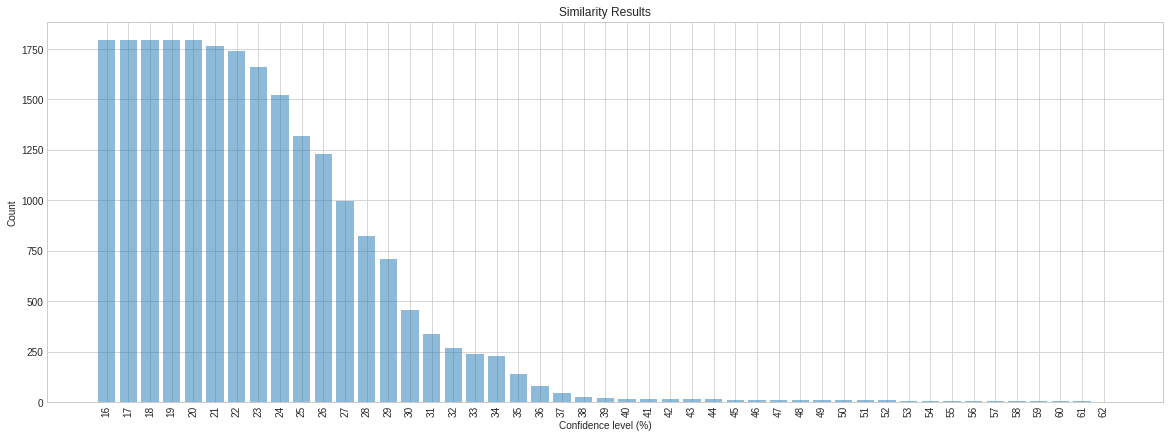

In [10]:
#@markdown View Results.

density_data = {}
for i in range(100, 0, -1):
  if i == 100:
    density_data[i] = len(df)
  else:
    density_data[i] = len(similarity_result.loc[similarity_result.confidence == i]) + density_data[i+1]

temp = density_data.copy()

min_value = temp[1]
max_value = temp[100]

for i in range(1, 101):
  if temp[i] == min_value:
    temp.pop(i)
  elif temp[i] == max_value:
    temp.pop(i)
  else:
    temp[i] = temp[i] - max_value


y_pos = temp.keys()
performance = temp.values()

with plt.style.context("seaborn-whitegrid"):  
  plt.figure(figsize=(20,7))
  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, y_pos)
  plt.ylabel('Count')
  plt.xlabel('Confidence level (%)')
  plt.title('Similarity Results')
  plt.xticks(rotation=90)
  plt.show()

# Results and Overview

Applying the confidence function for all of the similarity search results yields a distribution of patents by confidence score. At the highest levels of confidence less results will appear. As you move down the confidence distribution the number of results increases exponentially.

Not all results returned are guaranteed to be high quality, however the higher the confidence level the more likely a result is positive. Depending on the input set, the confidence levels will not necessarily begin at 99%. From the results above, using our “neural network” random patent set, the highest confidence results sit in the 60-70% range. From our own experimentation, the more tightly related the input set, the higher the confidence level in the results will be, since the clusters will be more compact.

This walkthrough provides one method for expanding a set of patents. Several changes or improvements can be made to the cluster algorithm, distance calculations and confidence functions to suit any dataset.


